In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_iters = 1000
#from cs231n.classifiers import LinearSVM
learning_len = 10
regularization_len = 10

learning_rates_list = np.linspace(learning_rates[0], learning_rates[1], learning_len)
regularization_strengths_list = np.linspace(regularization_strengths[0], regularization_strengths[1], regularization_len)

for learning_idx ,learning_rate in enumerate(learning_rates_list):
  for regularization_idx, regularization_strength in enumerate(regularization_strengths_list):
    # initialize new LinearSVM object
    print("{} out of {}".format((learning_idx+1,regularization_idx+1), (learning_len,regularization_len)))
    svm = LinearSVM()
    
    #train it with given hyperparameters
    svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=regularization_strength,
                        num_iters=num_iters, verbose=True)
    
    # predict with the trained svm, then calculate accuracy
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    
    # add result to results
    result_key = (learning_rate, regularization_strength)
    
    (training_accuracy, validation_accuracy) = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
    result_value = (training_accuracy, validation_accuracy)
    
    results[result_key] = result_value

    # find the best svm with the highest validation accuracy
    if best_val < validation_accuracy:
      best_svm = svm
      best_val = validation_accuracy
    
  
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

(1, 1) out of (10, 10)
iteration 0 / 1000: loss 8.998833
iteration 100 / 1000: loss 9.009760
iteration 200 / 1000: loss 9.002163
iteration 300 / 1000: loss 9.002488
iteration 400 / 1000: loss 8.998668
iteration 500 / 1000: loss 9.009677
iteration 600 / 1000: loss 8.991000
iteration 700 / 1000: loss 8.995236
iteration 800 / 1000: loss 8.994609
iteration 900 / 1000: loss 9.006405
(1, 2) out of (10, 10)
iteration 0 / 1000: loss 9.014971
iteration 100 / 1000: loss 9.006168
iteration 200 / 1000: loss 8.997019
iteration 300 / 1000: loss 9.010399
iteration 400 / 1000: loss 9.009511
iteration 500 / 1000: loss 9.001242
iteration 600 / 1000: loss 9.002910
iteration 700 / 1000: loss 8.989586
iteration 800 / 1000: loss 9.006675
iteration 900 / 1000: loss 8.995474
(1, 3) out of (10, 10)
iteration 0 / 1000: loss 8.990351
iteration 100 / 1000: loss 8.982724
iteration 200 / 1000: loss 8.984830
iteration 300 / 1000: loss 8.994580
iteration 400 / 1000: loss 8.996777
iteration 500 / 1000: loss 8.990388
i

In [ ]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.41


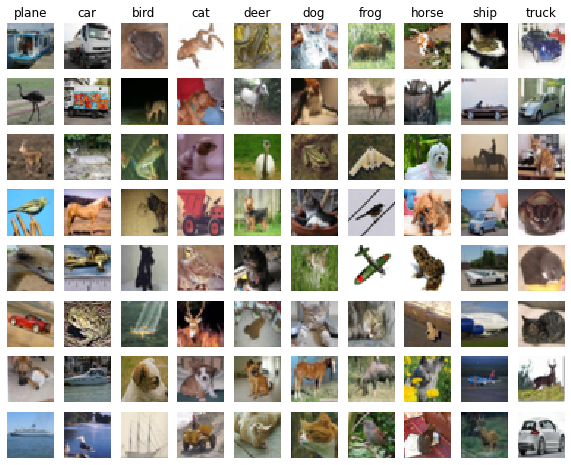

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [6]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


(Iteration 1 / 1430) loss: 43.004646
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.121000
(Iteration 101 / 1430) loss: 40.534575
(Iteration 201 / 1430) loss: 38.197546
(Epoch 1 / 5) train acc: 0.093000; val_acc: 0.135000
(Iteration 301 / 1430) loss: 36.022973
(Iteration 401 / 1430) loss: 34.078030
(Iteration 501 / 1430) loss: 32.215077
(Epoch 2 / 5) train acc: 0.131000; val_acc: 0.146000
(Iteration 601 / 1430) loss: 30.496229
(Iteration 701 / 1430) loss: 28.957615
(Iteration 801 / 1430) loss: 27.473841
(Epoch 3 / 5) train acc: 0.142000; val_acc: 0.163000
(Iteration 901 / 1430) loss: 26.115431
(Iteration 1001 / 1430) loss: 24.873481
(Iteration 1101 / 1430) loss: 23.686202
(Epoch 4 / 5) train acc: 0.190000; val_acc: 0.181000
(Iteration 1201 / 1430) loss: 22.594920
(Iteration 1301 / 1430) loss: 21.575588
(Iteration 1401 / 1430) loss: 20.618498
(Epoch 5 / 5) train acc: 0.191000; val_acc: 0.193000
 progress : 100.0%, 1 out of 1 done. ========================


batch_size 171 learning_rate 3

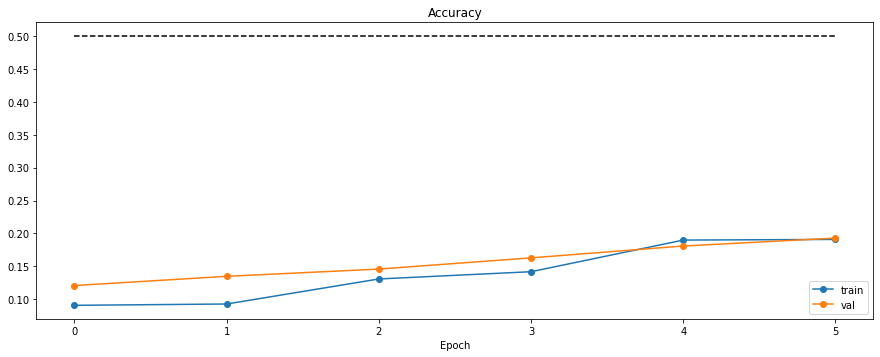

Text(0.5, 1.0, 'CIFAR-10 validation accuracy')

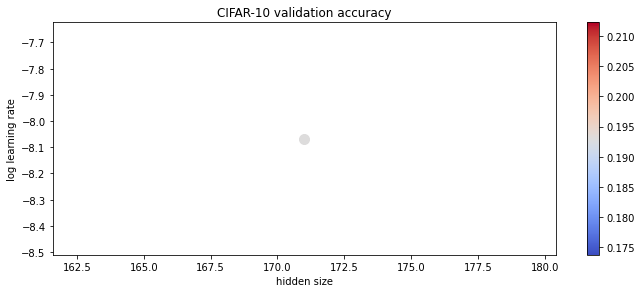

In [17]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from numpy.random import default_rng
rng = default_rng()

#######################################################################
# test note ###########################################################
#######################################################################

results = {}
best_val = -1
best_parameter = (0.0, 0.0) 

#######################################################################
# changable parameters ################################################
#######################################################################

# trial & epoch
num_trial = 1
num_epochs = 5

# constant variables 
reg = 1.0
lr_decay = 0.95

# test list
batch_size_list = rng.integers(low=50, high=200, size=num_trial)
learning_rate_list = (1e-3 - 1e-7) * rng.random(size=num_trial) + 1e-7
test_list = zip(batch_size_list, learning_rate_list)

#######################################################################
# Automated test ######################################################
#######################################################################

for i, (batch_size, learning_rate) in enumerate(test_list):

  # model
  model = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg,  weight_scale=1/np.sqrt(2 * hidden_dim))
  
  #solver
  solver = Solver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': learning_rate,
                  },
                  lr_decay=lr_decay,
                  num_epochs=num_epochs, batch_size=batch_size,
                  print_every=100)
  
  solver.train()
  
  # save in results
  results[(batch_size, learning_rate)] = solver.best_val_acc
  
  # if best, save val_acc, model
  if best_val <= solver.best_val_acc :
    best_val = solver.best_val_acc
    best_net = model
    best_parameter = (batch_size, learning_rate)
  
  #print progress
  progress = round(100 * (i+1) / num_trial, 2)
  print(" progress : {}%, {} out of {} done. ========================\n\n"
  .format(progress, i+1, num_trial))

#######################################################################
# Print test result ###################################################
#######################################################################

for (a, b) in sorted(results):
    print('batch_size %i learning_rate %e : val_accuracy: %f' % (
        a, b, results[(a, b)]))

print('==================================================================')   
print('best validation accuracy achieved during test:')   
print('batch_size %i learning_rate %e : val_accuracy: %f\n\n' % (
                best_parameter[0], best_parameter[1], best_val))

#######################################################################
# Visualization #######################################################
#######################################################################

import math
plt.figure(figsize=(10, 10))

# test color map
plt.subplot(2,1,1)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# accuracy-iteration graph
plt.subplot(2, 1, 2)
x_scatter = [key[0] for key in results]
y_scatter = [math.log(key[1]) for key in results]
colors = [results[key] for key in results]
marker_size = 100
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('hidden size')
plt.ylabel('log learning rate')
plt.title('CIFAR-10 validation accuracy')


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [18]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.172
